In [107]:
import numpy as np 
import plotly.express as px 
import pandas as pd 
import cv2 
import os 
from glob import glob
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
import pickle 

## Appending All files

In [108]:
df_list = []
for file_name in glob("../input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/*.txt"):
    df_temp = pd.read_csv(file_name, sep="\t")
    df_list.append(df_temp)
df = pd.concat(df_list, axis=0, ignore_index=True)
del df_list


In [109]:
df = df.dropna()


In [110]:
df['image_path'] = df[['user_id', 'face_id', 'original_image']].apply(
    lambda x: os.path.join('../input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/faces', f"{x[0]}", f"coarse_tilt_aligned_face.{x[1]}.{x[2]}"), axis=1)


In [111]:
age_mapper = {'35': '(38, 48)','34': '(38, 48)','36': '(38, 48)','55':'(60, 100)','57':'(60, 100)','58':'(60, 100)','23':'(8, 23)','3':'(0, 2)','2':'(0, 2)'}
for elem in df[df['age'].str.startswith("(")]['age'].value_counts().index:
    age_mapper[elem] = elem
df['age'] = df['age'].map(age_mapper)

In [112]:
df = df[df['age'] != 'None']

In [113]:
new_df = df[df['gender'] != 'u'][['age', 'gender', 'x', 'y', 'dx', 'dy','image_path']]

In [114]:
del df

In [115]:
new_df['gender'] = new_df['gender'].apply(lambda x : 1 if x == 'm' else 0).astype(np.float32)

In [116]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
new_df['age'] = le.fit_transform(new_df['age'])

In [117]:
with open('age_encoder.pkl','wb') as pkl_file:
    pickle.dump(le, pkl_file)

In [118]:
X = new_df[['image_path']].values 
y = new_df[['gender']].values 


In [119]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def preprocess_image(individual_path):
    img = tf.io.read_file(np.array(individual_path).ravel()[0]) 
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128,128])
    return img 

In [120]:
def yield_training_values(X_train,y_train):
    for image_path, value in zip(X_train, y_train):
        image = preprocess_image(image_path)
        yield image, value 

In [121]:
ds_train = tf.data.Dataset.from_generator(yield_training_values,
                                          args=[X_train, y_train],
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=([128, 128, 3], [1]))


ds_test = tf.data.Dataset.from_generator(yield_training_values,
                                          args=[X_test, y_test],
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=([128, 128, 3], [1]))


In [122]:
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.cache().shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=AUTOTUNE)

## Simple CNN Gender

In [123]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

# Assuming ds_train and ds_test are already defined
# Example for dataset loading (if not loaded):
# ds_train = ...
# ds_test = ...


In [124]:
inputs = tf.keras.Input(shape = (128,128,3))
x = Conv2D(128, 3, activation='relu')(inputs)
x = MaxPool2D((2,2))(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(32,(3), activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(32,(3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(2, activation='sigmoid')(x) 

model = tf.keras.Model(inputs, outputs)



In [125]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy')

In [126]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy')

In [127]:
history_gender = model.fit(
    ds_train, validation_data=ds_test, epochs=50
)


Epoch 1/50
438/438 [==============================] - 96s 207ms/step - loss: 0.8308 - accuracy: 0.5243 - val_loss: 0.7173 - val_accuracy: 0.4581
Epoch 2/50
438/438 [==============================] - 9s 20ms/step - loss: 0.7271 - accuracy: 0.5441 - val_loss: 0.8986 - val_accuracy: 0.4570
Epoch 3/50
438/438 [==============================] - 9s 20ms/step - loss: 0.7032 - accuracy: 0.5441 - val_loss: 0.7128 - val_accuracy: 0.5167
Epoch 4/50
438/438 [==============================] - 9s 20ms/step - loss: 0.6894 - accuracy: 0.5706 - val_loss: 0.7122 - val_accuracy: 0.4844
Epoch 5/50
438/438 [==============================] - 9s 20ms/step - loss: 0.6826 - accuracy: 0.5845 - val_loss: 0.7280 - val_accuracy: 0.4513
Epoch 6/50
438/438 [==============================] - 9s 20ms/step - loss: 0.6751 - accuracy: 0.5922 - val_loss: 0.8116 - val_accuracy: 0.5667
Epoch 7/50
438/438 [==============================] - 9s 20ms/step - loss: 0.6724 - accuracy: 0.5973 - val_loss: 0.6862 - val_accuracy: 0.55

In [128]:
def plot_training(history, title):
    """Plots the training and validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


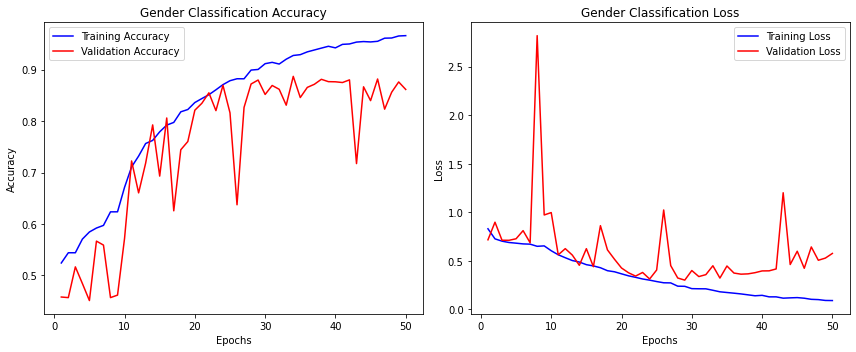

In [129]:
plot_training(history_gender, "Gender Classification")


In [130]:
model.save('my_model.h5')

**TESTING GENDER**

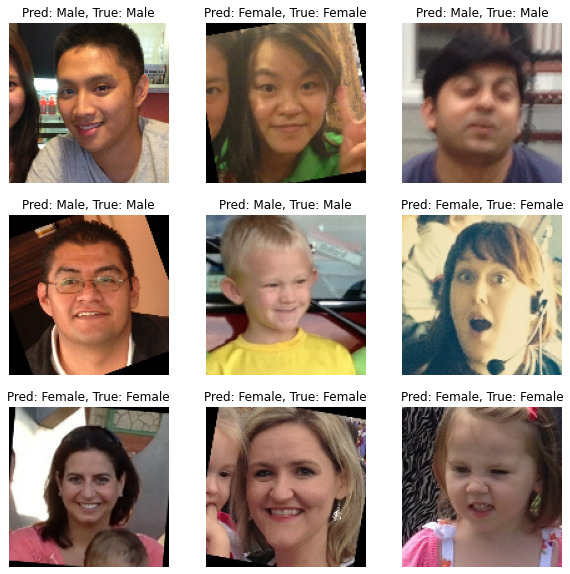

In [131]:
# Load the saved model
model = tf.keras.models.load_model('my_model.h5')

# Function to visualize the predictions
def visualize_predictions(ds_test):
    for image, true_label in ds_test.take(1):  # Get a batch of data
        predictions = model.predict(image)
        predicted_labels = np.argmax(predictions, axis=1)  # For sigmoid, you can use np.round() if binary
        true_label = np.array(true_label).flatten()  # Flatten true labels
        
        # Show images and their predictions
        plt.figure(figsize=(10, 10))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(image[i].numpy().astype("uint8"))
            plt.title(f"Pred: {'Male' if predicted_labels[i] == 1 else 'Female'}, True: {'Male' if true_label[i] == 1 else 'Female'}")
            plt.axis('off')
        plt.show()

# Call the function to visualize predictions on the test set
visualize_predictions(ds_test)


## Agumentation

In [80]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2,0.2),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    tf.keras.layers.Rescaling(1./255)
])

In [81]:
for image, _ in  ds_train.take(1):
    my_image = image 
image = my_image[2]
image = tf.cast(tf.expand_dims(image, 0), tf.float32)


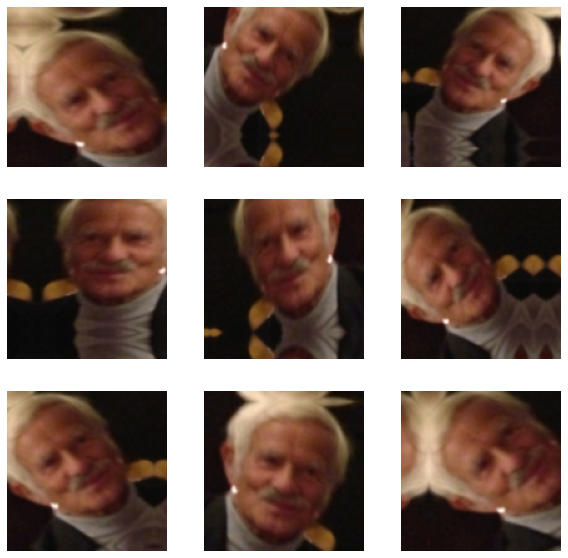

In [82]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [83]:
inputs = tf.keras.Input(shape = (128,128,3))
x = data_augmentation(inputs)
x = Conv2D(128, 3, activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Dropout(0.2)(x)
x = Conv2D(32,(3), activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(32,(3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)



callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy')

In [84]:
history = model.fit(ds_train, validation_data=ds_test,epochs=100)

Epoch 1/100
438/438 [==============================] - 11s 23ms/step - loss: 0.8401 - accuracy: 0.5197 - val_loss: 0.7026 - val_accuracy: 0.5433
Epoch 2/100
438/438 [==============================] - 10s 22ms/step - loss: 0.7435 - accuracy: 0.5218 - val_loss: 0.7094 - val_accuracy: 0.5164
Epoch 3/100
438/438 [==============================] - 10s 22ms/step - loss: 0.7127 - accuracy: 0.5326 - val_loss: 0.7073 - val_accuracy: 0.5567
Epoch 4/100
438/438 [==============================] - 10s 22ms/step - loss: 0.7091 - accuracy: 0.5233 - val_loss: 0.6989 - val_accuracy: 0.5613
Epoch 5/100
438/438 [==============================] - 10s 22ms/step - loss: 0.7045 - accuracy: 0.5376 - val_loss: 0.6849 - val_accuracy: 0.5510
Epoch 6/100
438/438 [==============================] - 10s 22ms/step - loss: 0.7027 - accuracy: 0.5416 - val_loss: 0.7292 - val_accuracy: 0.5602
Epoch 7/100
438/438 [==============================] - 10s 22ms/step - loss: 0.7077 - accuracy: 0.5263 - val_loss: 0.7834 - val_ac

In [85]:
model.save('simple_model_agumentation.h5')

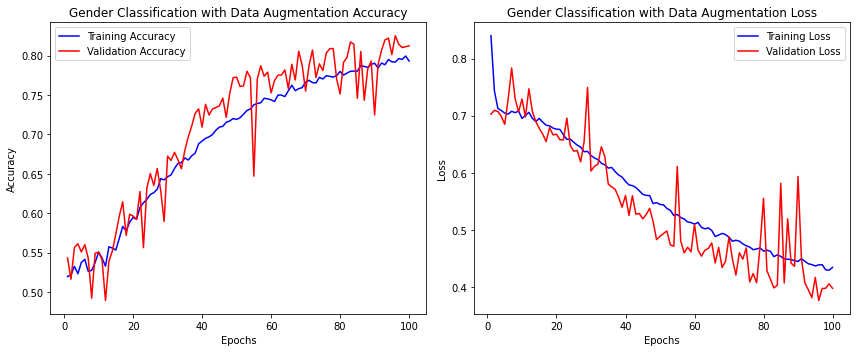

In [86]:
# Function to plot the training and validation accuracy and loss
def plot_training_augmented(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plotting the training and validation graphs
plot_training_augmented(history, "Gender Classification with Data Augmentation")


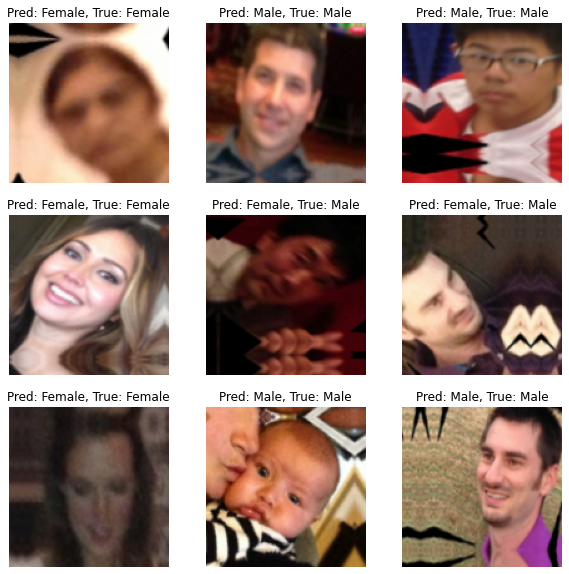

In [92]:
# Load the saved model with augmentation
model = tf.keras.models.load_model('simple_model_agumentation.h5')

# Function to visualize the augmented images and predictions
def visualize_predictions_augmented(ds_test):
    for image, true_label in ds_test.take(1):  # Get a batch of data
        augmented_images = []
        
        # Apply augmentation to the first 9 images in the batch
        for i in range(9):
            augmented_image = data_augmentation(image[i:i+1])  # Apply augmentation to individual images
            augmented_image = augmented_image[0].numpy()  # Convert the augmented image to numpy array
            
            # Rescale to 0-255 for visualization
            augmented_image = (augmented_image * 255).astype("uint8")
            augmented_images.append(augmented_image)  # Add to the list
        
        # Predictions for the augmented images
        predictions = model.predict(np.array(augmented_images))  # Predict on augmented images
        predicted_labels = np.argmax(predictions, axis=1)  # Get the predicted label (0 or 1)
        true_label = np.array(true_label).flatten()  # Flatten true labels

        # Show augmented images with predictions and true labels
        plt.figure(figsize=(10, 10))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[i])  # Visualize the augmented images
            plt.title(f"Pred: {'Male' if predicted_labels[i] == 1 else 'Female'}, True: {'Male' if true_label[i] == 1 else 'Female'}")
            plt.axis('off')
        plt.show()

# Call the function to visualize predictions on augmented images
visualize_predictions_augmented(ds_test)


## Age Model

In [93]:
X = new_df[['image_path']].values
y = new_df[['age']].values

def yield_training_values(X_train,y_train):
    for image_path, value in zip(X_train, y_train):
        image = preprocess_image(image_path)
        yield image, value 
        
def preprocess_image(individual_path):
    img = tf.io.read_file(np.array(individual_path).ravel()[0]) 
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128,128])
    return img 
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2,0.2),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    tf.keras.layers.Rescaling(1./255)
])

In [94]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [95]:
ds_train = tf.data.Dataset.from_generator(yield_training_values,
                                          args=[X_train, y_train],
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=([128, 128, 3], [1]))


ds_test = tf.data.Dataset.from_generator(yield_training_values,
                                          args=[X_test, y_test],
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=([128, 128, 3], [1]))


In [96]:
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.cache().shuffle(buffer_size=100).batch(32).prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().shuffle(buffer_size=100).batch(32).prefetch(buffer_size=AUTOTUNE)

In [98]:
inputs = tf.keras.Input(shape = (128,128,3))
x = data_augmentation(inputs)
x = Conv2D(128, 3, activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(64,(3), activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(32,(3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(13, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)



callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy')

In [99]:
history = model.fit(ds_train, validation_data=ds_test,epochs=200)

Epoch 1/200
465/465 [==============================] - 90s 190ms/step - loss: 2.5874 - accuracy: 0.2007 - val_loss: 2.1786 - val_accuracy: 0.2931
Epoch 2/200
465/465 [==============================] - 10s 22ms/step - loss: 2.2818 - accuracy: 0.2417 - val_loss: 2.2200 - val_accuracy: 0.2557
Epoch 3/200
465/465 [==============================] - 10s 22ms/step - loss: 2.2128 - accuracy: 0.2557 - val_loss: 2.2454 - val_accuracy: 0.2793
Epoch 4/200
465/465 [==============================] - 11s 23ms/step - loss: 2.1513 - accuracy: 0.2698 - val_loss: 2.0905 - val_accuracy: 0.2893
Epoch 5/200
465/465 [==============================] - 10s 22ms/step - loss: 2.1080 - accuracy: 0.2786 - val_loss: 2.5899 - val_accuracy: 0.2900
Epoch 6/200
465/465 [==============================] - 10s 22ms/step - loss: 2.0698 - accuracy: 0.2884 - val_loss: 2.0230 - val_accuracy: 0.3289
Epoch 7/200
465/465 [==============================] - 10s 22ms/step - loss: 2.0115 - accuracy: 0.3096 - val_loss: 2.3722 - val_a

In [100]:
model.save('image_model.h5')

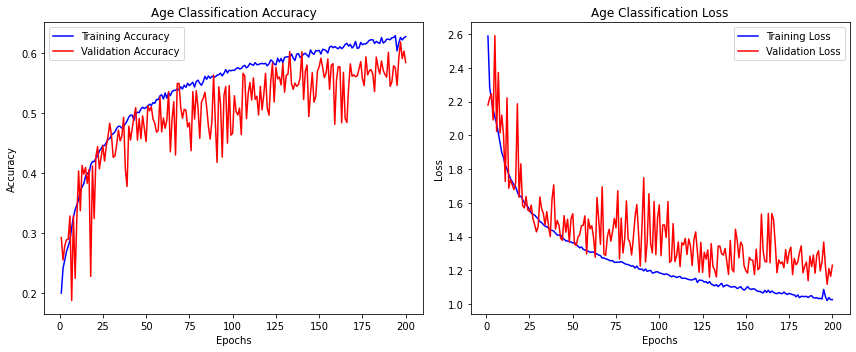

In [101]:
# Function to plot the training and validation accuracy and loss
def plot_training_age(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the function to visualize the training and validation graphs for age classification
plot_training_age(history, "Age Classification")


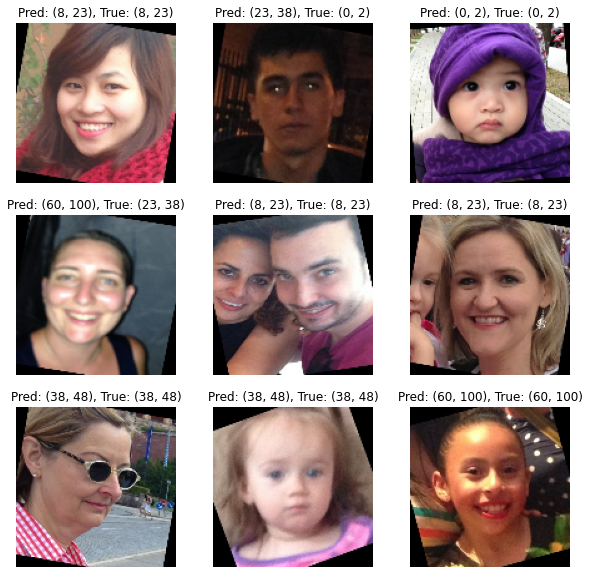

In [106]:
# Define the mapping of class indices to actual age ranges
age_range_mapping = {
    0: "(0, 2)",
    1: "(0, 2)",
    2: "(8, 23)",
    3: "(8, 23)",
    4: "(23, 38)",
    5: "(23, 38)",
    6: "(23, 38)",
    7: "(38, 48)",
    8: "(38, 48)",
    9: "(38, 48)",
    10: "(60, 100)",
    11: "(60, 100)",
    12: "(60, 100)"
}

# Function to visualize the predicted ages and true labels
def visualize_predictions_age(ds_test):
    for image, true_label in ds_test.take(1):  # Get a batch of data
        predictions = model.predict(image)  # Predict on the images
        predicted_labels = np.argmax(predictions, axis=1)  # Get the predicted class (age category)
        true_label = np.array(true_label).flatten()  # Flatten true labels

        # Show images with predicted and true age labels (mapping class to age range)
        plt.figure(figsize=(10, 10))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(image[i].numpy().astype("uint8"))  # Visualize the image
            # Convert predicted label to the corresponding age range using the mapping
            predicted_age_range = age_range_mapping[predicted_labels[i]]
            true_age_range = age_range_mapping[true_label[i]]
            plt.title(f"Pred: {predicted_age_range}, True: {true_age_range}")  # Show predicted and true age range
            plt.axis('off')
        plt.show()

# Call the function to visualize predictions on test images
visualize_predictions_age(ds_test)


In [34]:
import os

# Define the path to your dataset
dataset_path = '../input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification'

# List the directories and files in the dataset folder
dataset_files = os.listdir(dataset_path)

# Check if there's a 'faces' folder where images are stored
faces_folder = os.path.join(dataset_path, 'faces')
if os.path.exists(faces_folder):
    print(f"Images are stored in: {faces_folder}")
    image_files = os.listdir(faces_folder)
    print(f"Number of images in the 'faces' folder: {len(image_files)}")
else:
    print("No 'faces' folder found.")

# Check if there's any CSV or text file with labels
label_files = [file for file in dataset_files if file.endswith('.txt') or file.endswith('.csv')]
print(f"Label files found: {label_files}")

# Check a sample of the first few lines of one of the label files
if label_files:
    sample_label_file = os.path.join(dataset_path, label_files[0])
    with open(sample_label_file, 'r') as f:
        sample_lines = f.readlines()[:10]  # Show the first 10 lines
    print(f"Sample lines from label file '{label_files[0]}':\n")
    for line in sample_lines:
        print(line.strip())
else:
    print("No label files found.")


Images are stored in: ../input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/faces
Number of images in the 'faces' folder: 168
Label files found: ['fold_0_data.txt', 'fold_3_data.txt', 'fold_2_data.txt', 'fold_1_data.txt', 'fold_4_data.txt']
Sample lines from label file 'fold_0_data.txt':

user_id	original_image	face_id	age	gender	x	y	dx	dy	tilt_ang	fiducial_yaw_angle	fiducial_score
30601258@N03	10399646885_67c7d20df9_o.jpg	1	(25, 32)	f	0	414	1086	1383	-115	30	17
30601258@N03	10424815813_e94629b1ec_o.jpg	2	(25, 32)	m	301	105	640	641	0	0	94
30601258@N03	10437979845_5985be4b26_o.jpg	1	(25, 32)	f	2395	876	771	771	175	-30	74
30601258@N03	10437979845_5985be4b26_o.jpg	3	(25, 32)	m	752	1255	484	485	180	0	47
30601258@N03	11816644924_075c3d8d59_o.jpg	2	(25, 32)	m	175	80	769	768	-75	0	34
30601258@N03	11562582716_dbc2eb8002_o.jpg	1	(25, 32)	f	0	422	1332	1498	-100	15	54
30601258@N03	10424595844_1009c687e4_o.jpg	4	(38, 43)	f	1912	905	1224	1224	155	0	64
3

In [39]:
import os

images_dir = "../input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/faces"
image_paths = []

# Recursively search for image files in subdirectories
for root, _, files in os.walk(images_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))

print(f"Found {len(image_paths)} images.")
print("Sample image paths:", image_paths[:5])  # Display first 5 image paths


Found 19370 images.
Sample image paths: ['../input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/faces/10611527@N03/coarse_tilt_aligned_face.872.8403974894_072288a6e8_o.jpg', '../input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/faces/10611527@N03/coarse_tilt_aligned_face.867.8403975240_68fe102b41_o.jpg', '../input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/faces/10611527@N03/coarse_tilt_aligned_face.866.8403975882_a3abea6314_o.jpg', '../input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/faces/10611527@N03/coarse_tilt_aligned_face.873.8403974894_072288a6e8_o.jpg', '../input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/faces/10611527@N03/coarse_tilt_aligned_face.875.8402870691_803973b06b_o.jpg']
